In [170]:
%matplotlib widget

isdark = False

from rayoptics.environment import *

In [171]:
opm = OpticalModel()
sm  = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']

osp['pupil'] = PupilSpec(osp, key=['object', 'pupil'], value=16)
osp['fov'] = FieldSpec(osp, key=['object', 'angle'], value=5, flds=[0., 0.707, 1.], is_relative=True)
osp['wvls'] = WvlSpec([('F', 0.5), (587.5618, 1.0), ('C', 0.5)], ref_wl=1)

opm.radius_mode = True

sm.gaps[0].thi=1e10

def calc_curvature(n, fl):
    return (n-1)*fl

n_bk7 = 1.5168
n_lasf9 = 1.85025
n_f2 =  1.62005

v_bk7 = 64.17
v_lasf9 = 32.16
v_f2 = 36.43
# try for chaining a 3x telescope setup with a second 3x telescope setup
f0 = 150
f0_0 = (v_bk7-v_f2)*f0/v_bk7
f0_1 = -f0_0*v_bk7/v_f2
f0_actual = 1/(1/f0_0+1/f0_1)
f1 = 60
# 1/f = 1/f0 + 1/f1 = 1/f0 - v2/(f0*v1) = (v1-v2)/(v1*f0)
# f0 = (v1-v2)*f/v1
f1_0 = (v_bk7-v_f2)*f1/v_bk7
f1_1 = -f1_0*v_bk7/v_f2

f2 = 150
f3 = 50

f1_stacked = 2*f1

r0 = calc_curvature(n_lasf9, f0)
r0_0 = calc_curvature(n_bk7, f0_0)
r0_1 = calc_curvature(n_f2, f0_1)
r1 = calc_curvature(n_lasf9, f1)
r1_0 = calc_curvature(n_bk7, f1_0)
r1_1 = calc_curvature(n_f2, f1_1)
r2 = calc_curvature(n_lasf9, f2)
r3 = calc_curvature(n_lasf9, f3)

#sm.add_surface([r0_0, 2, 'N-BK7', 'Schott', 42/2])
#sm.add_surface([1e9, 2, 'N-F2', 'Schott', 42/2])
#sm.add_surface([-r0_1, 180+2*f1])
#sm.add_surface([-r0_1, 180+2*36.])

sm.add_surface([r1_0, 4, 'N-BK7', 'Schott', 16])
sm.add_surface([1e9, 2, 'N-F2', 'Schott', 16])
sm.add_surface([-r1_1, 30])
#sm.add_surface([1e9, 2, 'N-LASF9', 'Schott', 16])
#sm.add_surface([-r1, f2+f3])


#sm.add_surface([r2, 2, 'N-LASF9', 'Schott', 16])
#sm.add_surface([1e9, f2+f3])
#sm.add_surface([1e9, 2, 'N-LASF9', 'Schott', 16])
#sm.add_surface([-r3, f3])

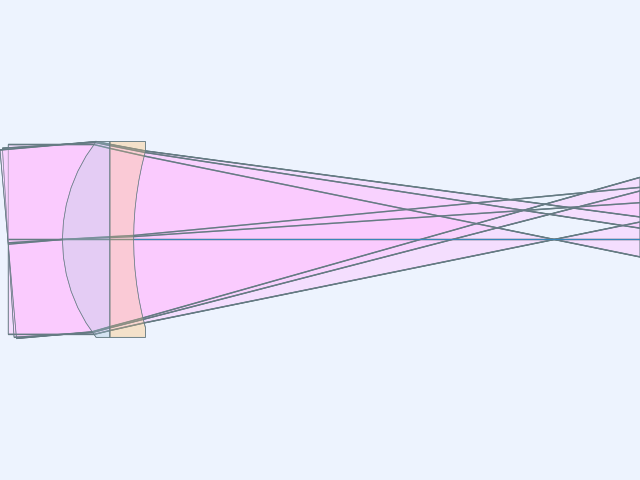

In [54]:
opm.update_model()
opm.seq_model.gaps[-1].thi = opm.optical_spec.parax_data.fod.bfl
opm.update_model()

layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, is_dark=isdark).plot()

In [55]:
pm.first_order_data()

efl               50.17
ffl              -54.42
pp1              -4.251
bfl               42.68
ppk               7.488
f/#               3.135
m            -5.017e-09
red          -1.993e+08
obj_dist          1e+10
obj_ang               5
enp_dist             -0
enp_radius            8
na obj            8e-10
n obj                 1
img_dist          42.68
img_ht            4.389
exp_dist         -3.569
exp_radius        7.375
na img          -0.1575
n img                 1
optical invariant       0.6999


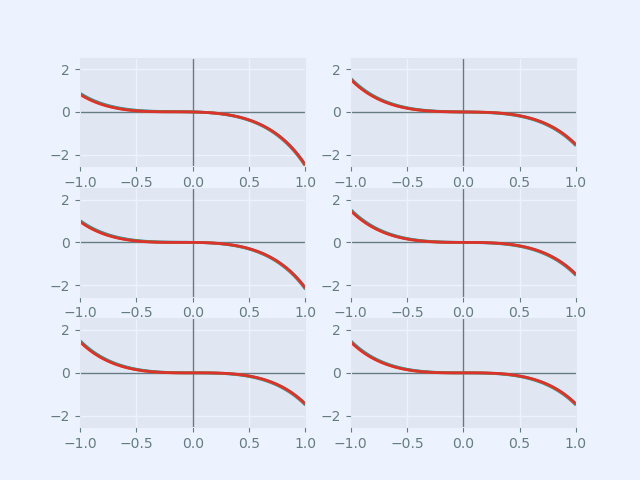

In [56]:
abr_plt = plt.figure(FigureClass=RayFanFigure, opt_model=opm, data_type='Ray',
                     scale_type=Fit.All_Same).plot()

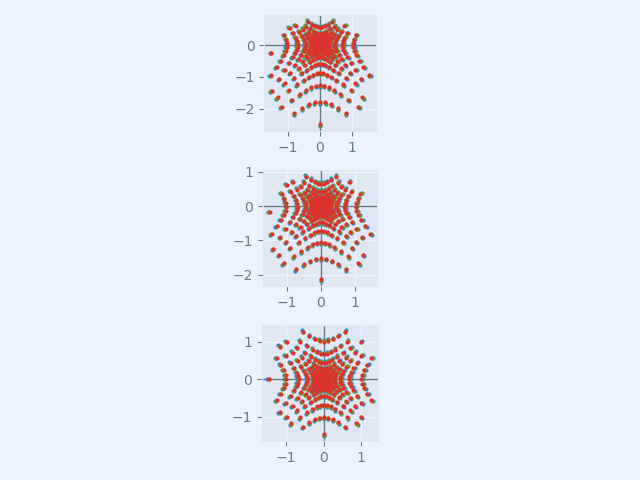

In [57]:
spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, is_dark=isdark).plot()

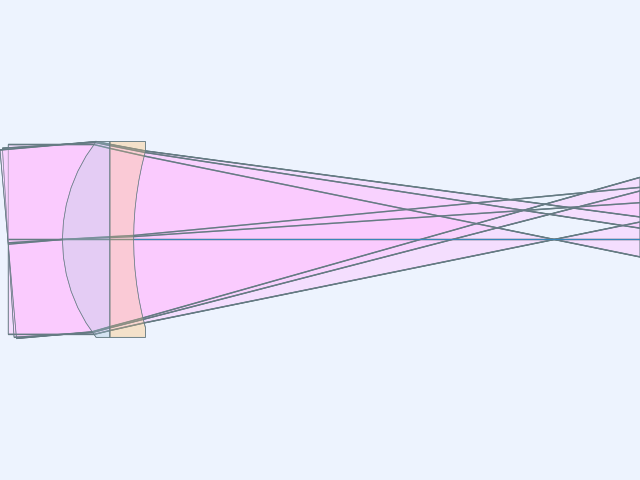

In [58]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, is_dark=isdark).plot()

In [59]:
def dump_dist(p, wi, ray_pkg, fld, wvl, foc):
    if ray_pkg is not None:
        image_pt = fld.ref_sphere[0]
        ray = ray_pkg[0]
        dist = foc / ray[-1][1][2]
        defocused_pt = ray[-1][0] + dist*ray[-1][1]
        t_abr = defocused_pt - image_pt
        return np.sqrt(np.sum(t_abr*t_abr))
    
def spot_rms(sm):
    return np.sqrt(np.mean(np.square(sm.trace_grid(dump_dist, 0, form='list', append_if_none=False)[0]), axis=1))

spot_rms(sm)

array([0.71394997, 0.69072105, 0.67781734])

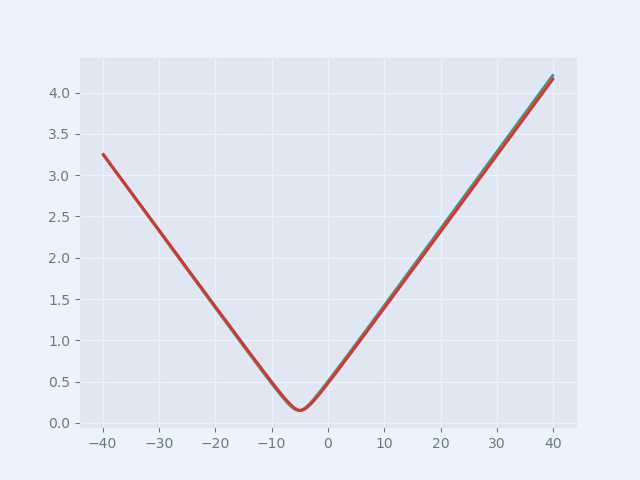

-5.022511255627812

In [60]:
import rayoptics.optical.model_constants as mc

old_gap = opm.seq_model.gaps[-1].thi
offsets = np.linspace(-40, 40, 2000)

opm.seq_model.gaps[-1].thi = opm.optical_spec.parax_data.fod.bfl
opm.update_model()

def dump_rays(p, wi, ray_pkg, fld, wvl, foc):
    if ray_pkg is not None:
        image_pt = fld.ref_sphere[0]
        ray = ray_pkg[mc.ray]
        v = ray[-1][mc.d][0:2] / ray[-1][mc.d][2]
        return [ray[-1][mc.p][0:2] - image_pt[0:2], v]

vals, colors = sm.trace_grid(dump_rays, 0, form='list', append_if_none=False)
v1, v2, v3 = vals
v1_p = v1[:,0]
v1_v = v1[:,1]
v2_p = v2[:,0]
v2_v = v2[:,1]
v3_p = v3[:,0]
v3_v = v3[:,1]

v1_rms = np.zeros(offsets.size)
v2_rms = np.zeros(offsets.size)
v3_rms = np.zeros(offsets.size)

for i in range(offsets.size):
    v1_rms[i] = np.sqrt(np.mean(np.square(v1_p+v1_v*offsets[i])))
    v2_rms[i] = np.sqrt(np.mean(np.square(v2_p+v2_v*offsets[i])))
    v3_rms[i] = np.sqrt(np.mean(np.square(v3_p+v3_v*offsets[i])))

opm.seq_model.gaps[-1].thi = old_gap
opm.update_model()

plt.figure()
plt.plot(offsets, v1_rms, color=colors[0])
plt.plot(offsets, v2_rms, color=colors[1])
plt.plot(offsets, v3_rms, color=colors[2])
plt.show()

min_o = offsets[np.argmin(0.25*v1_rms+0.50*v2_rms+0.25*v3_rms)]
min_o

[0.2159279  0.21609438 0.21714886]


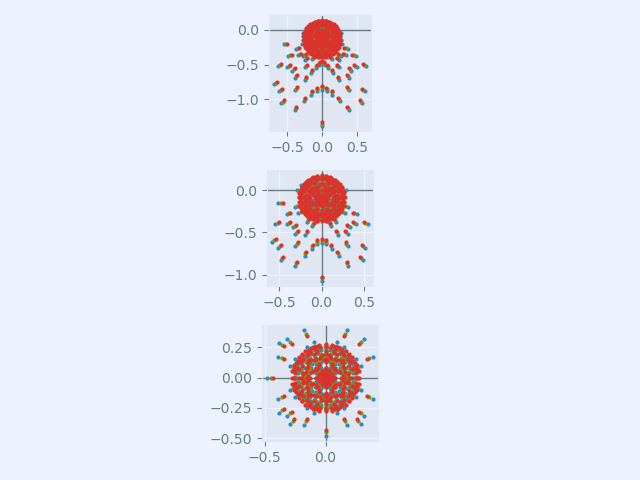

In [61]:
opm.seq_model.gaps[-1].thi = opm.optical_spec.parax_data.fod.bfl + min_o
opm.update_model()

spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, is_dark=isdark).plot()
print(spot_rms(sm))

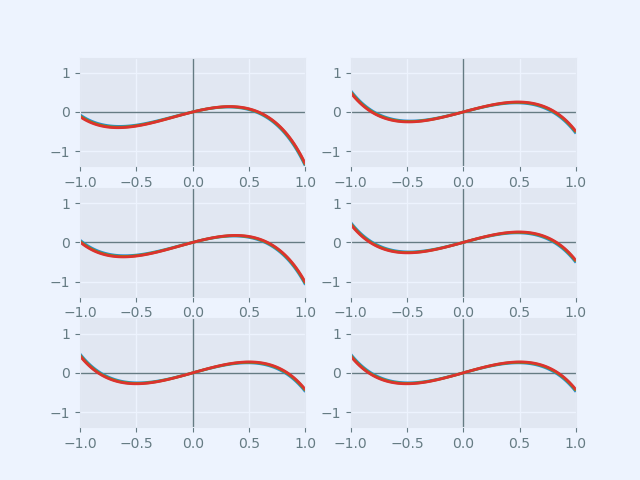

In [62]:
abr_plt = plt.figure(FigureClass=RayFanFigure, opt_model=opm, data_type='Ray',
                     scale_type=Fit.All_Same).plot()

In [12]:
# let's try chaining the two lenses together and seeing how that looks

# first let's wrap that focus calculation code into a function


def dump_rays(p, wi, ray_pkg, fld, wvl, foc):
    if ray_pkg is not None:
        image_pt = fld.ref_sphere[0]
        ray = ray_pkg[mc.ray]
        v = ray[-1][mc.d][0:2] / ray[-1][mc.d][2]
        return [ray[-1][mc.p][0:2] - image_pt[0:2], v]
    
def get_focus(sm, offset=False, weights=np.array([0.25, 0.5, 0.25])):
    offsets = np.linspace(-40, 40, 2000)
    vals, colors = sm.trace_grid(dump_rays, 0, form='list', append_if_none=False)

    rms = np.zeros((offsets.size, len(vals)), dtype=float)

    for i in range(offsets.size):
        for j in range(len(vals)):
            rms[i][j] = np.sqrt(np.mean(np.square(vals[j][:,0]+vals[j][:,1]*offsets[i])))

    if offset:
        return offsets[np.argmin(np.sum(rms*weights, axis=1))]
    else:
        return sm.gaps[-1].thi + offsets[np.argmin(np.sum(rms*weights, axis=1))]

get_focus(sm)

37.675382106540546

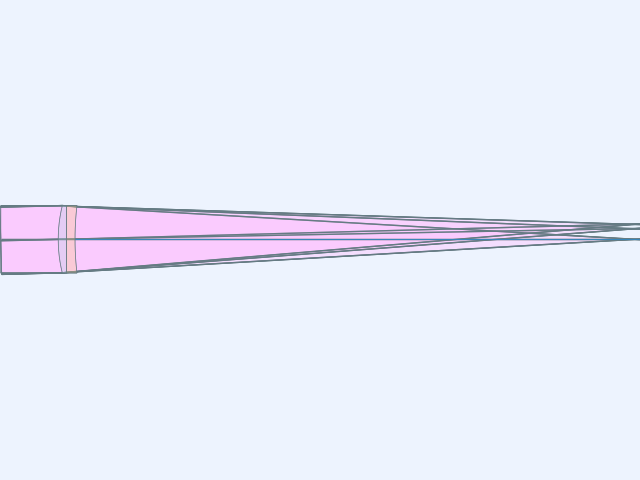

In [150]:
opm2 = OpticalModel()
sm2  = opm2['seq_model']
osp2 = opm2['optical_spec']
pm2 = opm2['parax_model']

osp2['pupil'] = PupilSpec(osp2, key=['object', 'pupil'], value=16)
osp2['fov'] = FieldSpec(osp2, key=['object', 'angle'], value=1.5, flds=[0., 0.707, 1.], is_relative=True)
osp2['wvls'] = WvlSpec([('F', 0.5), (587.5618, 1.0), ('C', 0.5)], ref_wl=1)

opm2.radius_mode = True

sm2.gaps[0].thi=1e10
sm2.add_surface([r0_0, 2, 'N-BK7', 'Schott', 42/2])
sm2.add_surface([1e9, 2, 'N-F2', 'Schott', 42/2])
sm2.add_surface([-r0_1, f0])
first_gap_idx = sm2.cur_surface

opm2.update_model()
sm2.gaps[-1].thi = get_focus(sm2)

opm2.update_model()

layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm2, is_dark=isdark).plot()

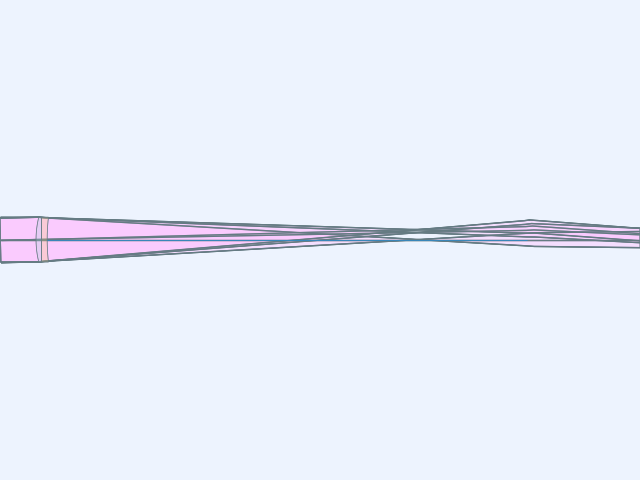

In [151]:
#use the gap from sm
sm2.gaps[-1].thi += sm.gaps[-1].thi

sm2.add_surface([r1_1, 1, 'N-F2', 'Schott', 16])
sm2.add_surface([1e9, 2, 'N-BK7', 'Schott', 16])
sm2.add_surface([-r1_0, sm.gaps[-1].thi])
second_gap_idx = sm2.cur_surface

opm2.update_model()
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm2, is_dark=isdark).plot()


In [152]:
pm2.first_order_data()

efl               505.1
ffl                1173
pp1                1678
bfl              -136.6
ppk               641.7
f/#               31.57
m            -5.051e-08
red           -1.98e+07
obj_dist          1e+10
obj_ang             1.5
enp_dist             -0
enp_radius            8
na obj            8e-10
n obj                 1
img_dist         -136.6
img_ht            13.23
exp_dist         -93.21
exp_radius        3.446
na img         -0.01584
n img                 1
optical invariant       0.2095


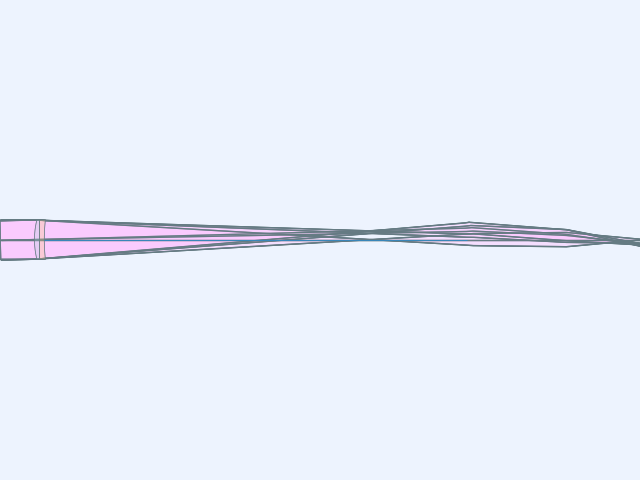

In [153]:
sm2.insert_surface_and_gap()
cur = sm2.cur_surface
sm2.ifcs[cur] = ThinLens(power=1/30.)
sm2.gaps[cur].thi = 30.

opm2.update_model()
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm2, is_dark=isdark).plot()

[0.51212369 0.14586092 0.10640832]


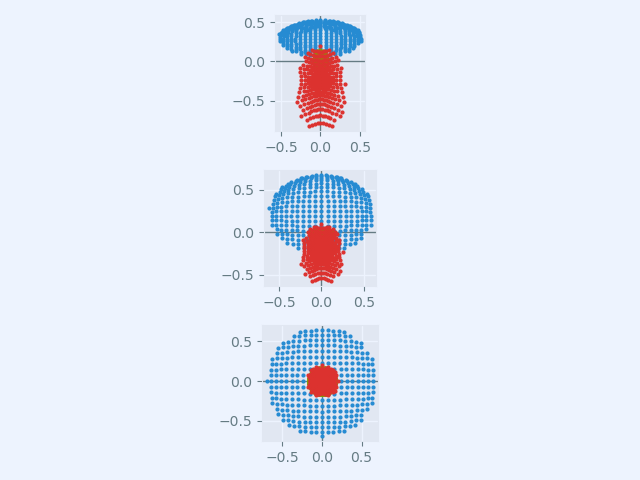

In [154]:
spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm2, is_dark=isdark).plot()
print(spot_rms(sm2))

(32.26113056528264, array([0.39920801, 0.02495399, 0.26426542]))

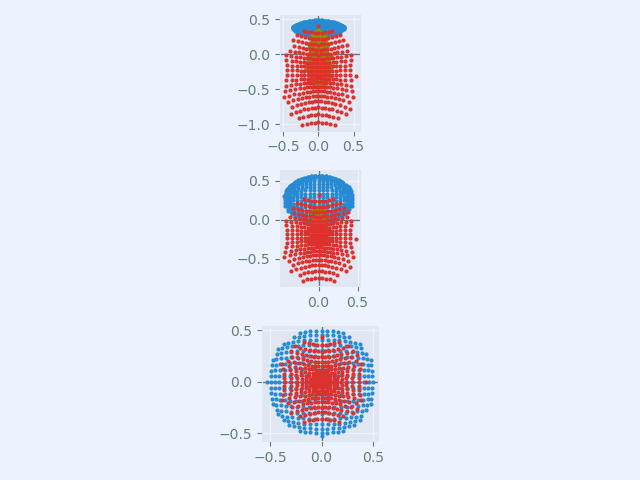

In [155]:
adjust = get_focus(sm2)
sm2.gaps[-1].thi = adjust

opm2.update_model()
spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm2, is_dark=isdark).plot()
adjust, spot_rms(sm2)

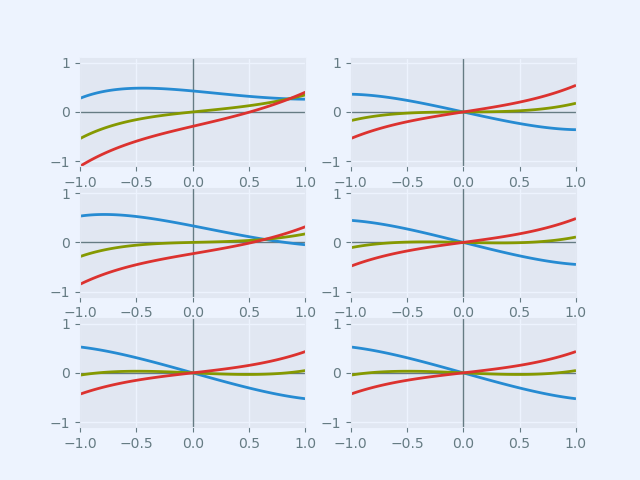

In [156]:
abr_plt = plt.figure(FigureClass=RayFanFigure, opt_model=opm2, data_type='Ray',
                     scale_type=Fit.All_Same).plot()

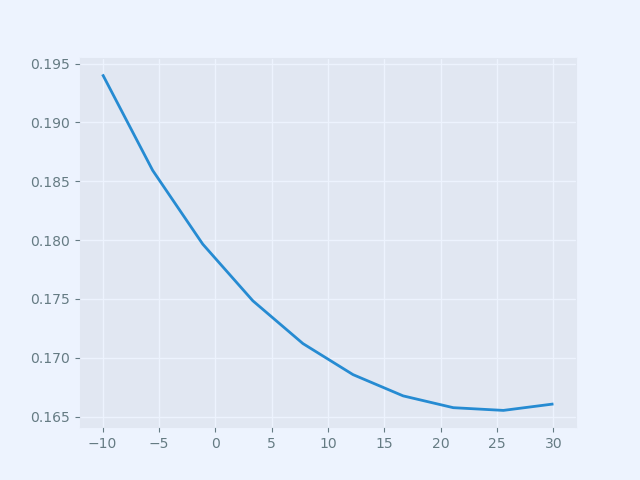

In [157]:
def test_gap(opm, sm, gap_idx, start, end, npoints=10, weights=np.array([0.25, 0.5, 0.25])):
    last_gap = sm.gaps[gap_idx].thi
    focus_gap = sm.gaps[-1].thi

    offsets = np.linspace(start, end, npoints)
    test_rms = np.zeros(offsets.size)
    for i in range(offsets.size):
        sm.gaps[gap_idx].thi = last_gap + offsets[i]
        opm.update_model()
        sm.gaps[-1].thi = get_focus(sm)
        opm.update_model()
        test_rms[i] = np.sum(spot_rms(sm)*weights)
    sm.gaps[gap_idx].thi = last_gap
    sm.gaps[-1].thi = focus_gap
    opm.update_model()
    return offsets, test_rms
    
offsets, test_rms = test_gap(opm2, sm2, first_gap_idx, -10, 30)
plt.figure()
plt.plot(offsets, test_rms)

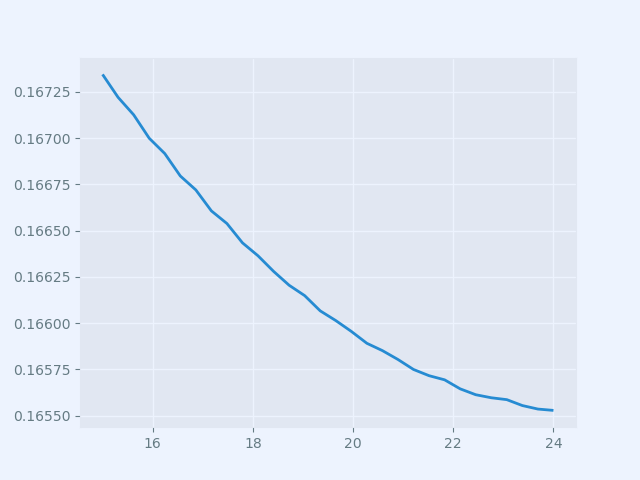

In [158]:
offsets, test_rms = test_gap(opm2, sm2, first_gap_idx, 15, 24, 30)

plt.figure()
plt.plot(offsets, test_rms)

In [159]:
# turned off to see how optimizing the second gap affects the quality by itself

#sm2.gaps[first_gap_idx].thi += offsets[np.argmin(test_rms)]
#opm2.update_model()

#offsets[np.argmin(test_rms)], np.min(test_rms)

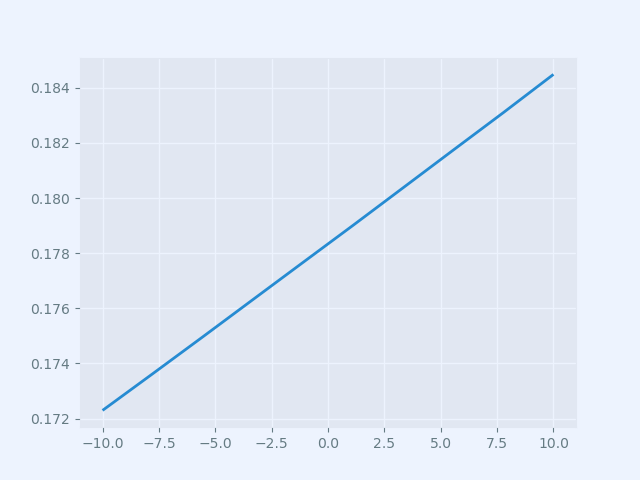

In [160]:
offsets2, test_rms2 = test_gap(opm2, sm2, second_gap_idx, -10, 10)
plt.figure()
plt.plot(offsets2, test_rms2)

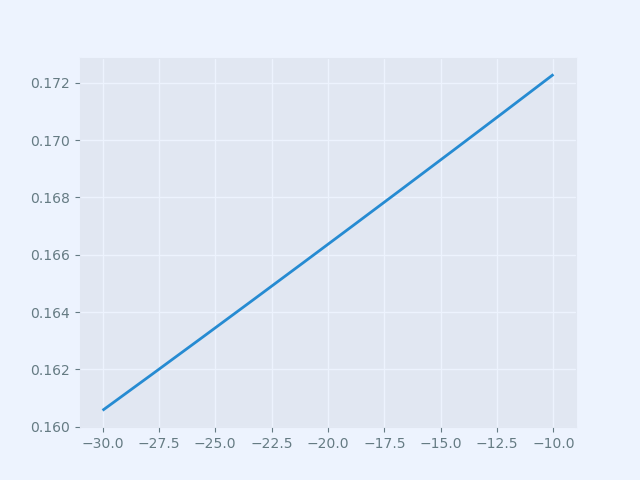

In [161]:
offsets2, test_rms2 = test_gap(opm2, sm2, second_gap_idx, -30, -10)
plt.figure()
plt.plot(offsets2, test_rms2)

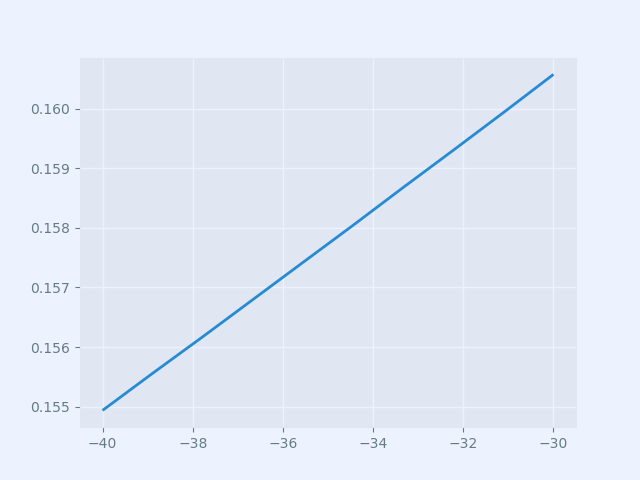

In [162]:
offsets2, test_rms2 = test_gap(opm2, sm2, second_gap_idx, -40, -30)
plt.figure()
plt.plot(offsets2, test_rms2)

In [163]:
# fuck how negative can it go?

sm2.gaps[second_gap_idx].thi


37.65537210153805

array([0.38273603, 0.06067967, 0.16915498])

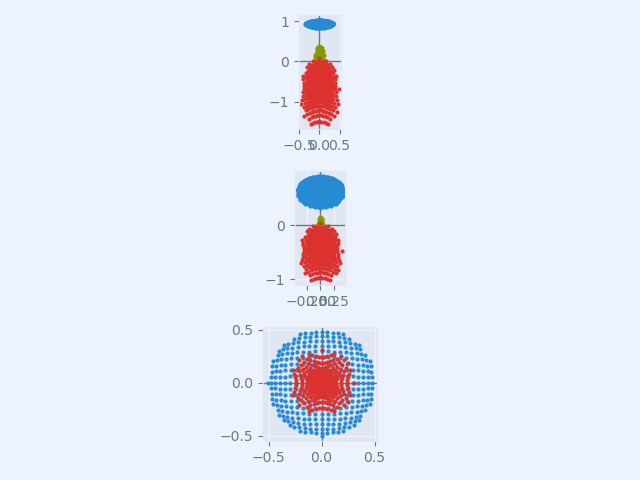

In [164]:
# let's place it at 2mm and see how that looks
sm2.gaps[second_gap_idx].thi = 2

sm2.gaps[-1].thi = get_focus(sm2)
opm2.update_model()

spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm2, is_dark=isdark).plot()
spot_rms(sm2)

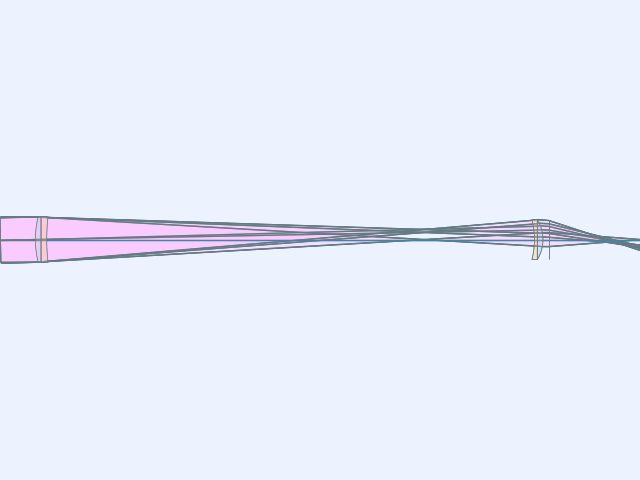

In [165]:
opm2.rebuild_from_seq()
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm2, is_dark=isdark).plot()

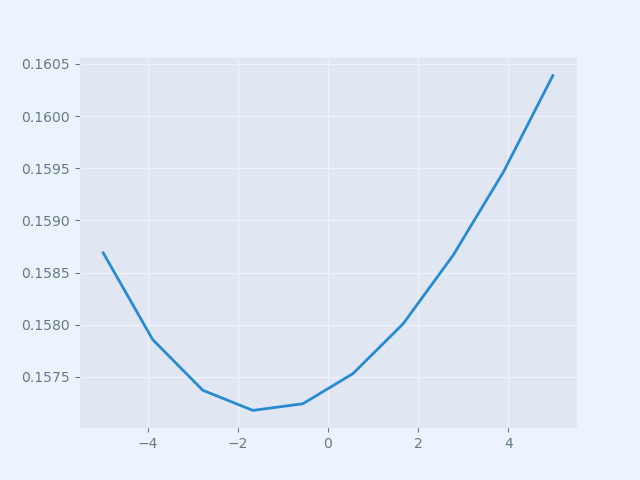

In [166]:
# let's try messing with the first gap again

offsets, test_rms = test_gap(opm2, sm2, first_gap_idx, -5, 5)
plt.figure()
plt.plot(offsets, test_rms)

In [167]:
# looks like it's pretty close to optimal, guess we'll have to mess with the first lens
# to optimize for this second one

# to be continued in part 2, 4D multivariable optimization
# probably gonna switch optics libraries too,
# this ray-optics is good but kind of slow